In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Training data
app_train = pd.read_csv('dataset/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## DATASET APPLICATION

In [3]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [4]:
from sklearn.impute import SimpleImputer

col_num = list(app_train.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_mean.fit_transform(app_train[col_num])

In [5]:
col_num = list(app_train.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_meanN.fit_transform(app_train[col_num])

In [6]:

col_obj = list(app_train.select_dtypes('object').columns)
imp_cons = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NonRenseigne')
app_train[col_obj] = imp_cons.fit_transform(app_train[col_obj])

## Label Encoding et One Hot Encoding

In [7]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    106
object      16
dtype: int64

In [8]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            app_train[col] = le.fit_transform(app_train[col])
            print('transformation colonne label encoding %s.' % col)            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

transformation colonne label encoding NAME_CONTRACT_TYPE.
transformation colonne label encoding FLAG_OWN_CAR.
transformation colonne label encoding FLAG_OWN_REALTY.
3 columns were label encoded.


In [9]:
# one-hot encoding of categorical variables
print('Training Features shape avant : ', app_train.shape)

app_train = pd.get_dummies(app_train)

print('Training Features shape apres : ', app_train.shape)

Training Features shape avant :  (307511, 122)
Training Features shape apres :  (307511, 249)


In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

uint8      140
float64    106
int32        3
dtype: int64

## retour analyse EDA

In [11]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = ( app_train["DAYS_EMPLOYED"] == 365243 ).map(int)

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

app_train['DAYS_EMPLOYED_ANOM'].value_counts()

0    252137
1     55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income | ratio total emprunt revenu
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income | taux endetemment
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [12]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [13]:
app_train[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CREDIT_INCOME_PERCENT',
           'AMT_ANNUITY','AMT_INCOME_TOTAL', 'ANNUITY_INCOME_PERCENT',
           'AMT_ANNUITY', 'AMT_CREDIT','CREDIT_TERM',
           'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED_PERCENT' ]]

,AMT_CREDIT,AMT_INCOME_TOTAL,CREDIT_INCOME_PERCENT,AMT_ANNUITY,AMT_INCOME_TOTAL,ANNUITY_INCOME_PERCENT,AMT_ANNUITY,AMT_CREDIT,CREDIT_TERM,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_EMPLOYED_PERCENT
0,406597.5,202500.0,2.007889,24700.5,202500.0,0.121978,24700.5,406597.5,0.060749,-637.0,-9461.0,0.067329
1,1293502.5,270000.0,4.790750,35698.5,270000.0,0.132217,35698.5,1293502.5,0.027598,-1188.0,-16765.0,0.070862
2,135000.0,67500.0,2.000000,6750.0,67500.0,0.100000,6750.0,135000.0,0.050000,-225.0,-19046.0,0.011814
3,312682.5,135000.0,2.316167,29686.5,135000.0,0.219900,29686.5,312682.5,0.094941,-3039.0,-19005.0,0.159905
4,513000.0,121500.0,4.222222,21865.5,121500.0,0.179963,21865.5,513000.0,0.042623,-3038.0,-19932.0,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,254700.0,157500.0,1.617143,27558.0,157500.0,0.174971,27558.0,254700.0,0.108198,-236.0,-9327.0,0.025303
307507,269550.0,72000.0,3.743750,12001.5,72000.0,0.166687,12001.5,269550.0,0.044524,0.0,-20775.0,-0.000000
307508,677664.0,153000.0,4.429176,29979.0,153000.0,0.195941,29979.0,677664.0,0.044239,-7921.0,-14966.0,0.529266
307509,370107.0,171000.0,2.164368,20205.0,171000.0,0.118158,20205.0,370107.0,0.054592,-4786.0,-11961.0,0.400134


# Ajout des donnees exterieures

In [14]:
# Read in bureau
bureau = pd.read_csv('dataset/bureau.csv')


In [15]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [16]:
# Join to the training dataframe
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_NonRenseigne,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts
0,100002.0,1.0,0,0,1,0.0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,0,0,2.007889,0.121978,0.060749,0.067329,8.0
1,100003.0,0.0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,4.790750,0.132217,0.027598,0.070862,4.0
2,100004.0,0.0,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,0,0,1,0,0,2.000000,0.100000,0.050000,0.011814,2.0
3,100006.0,0.0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,0,0,1,0,0,2.316167,0.219900,0.094941,0.159905,0.0
4,100007.0,0.0,0,0,1,0.0,121500.0,513000.0,21865.5,513000.0,...,0,0,1,0,0,4.222222,0.179963,0.042623,0.152418,1.0


In [17]:
app_train.isna().sum()

SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                         ..
CREDIT_INCOME_PERCENT     0
ANNUITY_INCOME_PERCENT    0
CREDIT_TERM               0
DAYS_EMPLOYED_PERCENT     0
previous_loan_counts      0
Length: 255, dtype: int64

# BASELINE

In [28]:
import re
from collections import Counter

app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = app_train.drop(columns='TARGET').copy()
y = app_train['TARGET'].copy()


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1944)

In [30]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226148, 1.0: 19860})
y_val Counter({0.0: 56538, 1.0: 4965})


### definition metrique et fonction evaluation

In [31]:
# il est important de faire ressortir les FNs car perte de capital
# trouver les TP est interessant aussi car interet
# les FP sont moins risqués car perte d'interet seulement
def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
# Fowlkes–Mallows index 
# https://en.wikipedia.org/wiki/Confusion_matrix
# https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index
# Positive predictive value PPV
    PPV = TP / (TP + FP)
# Positive predictive value TPR
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred,2)

In [32]:
from sklearn.metrics import make_scorer

custom_scorer = make_scorer(custom_metric, greater_is_better=True )
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True )

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score

def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred,2):.3}')
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## comparaison hasard Dummy

[[51859  4679]
 [ 4573   392]]
Accuracy score    : 0.85
precision score   : 0.0773
recall score      : 0.079
F1 score          : 0.0781
F2 score          : 0.0786
ROCAUC score      : 0.498
custom metric FMI : 0.0781



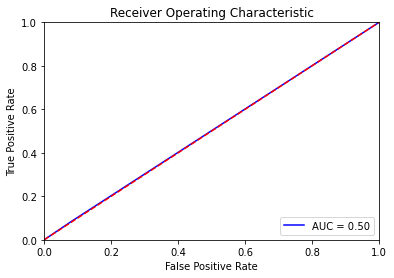

In [34]:
from sklearn.dummy import DummyClassifier

dummyCls = DummyClassifier(strategy='stratified')
dummyCls.fit(X_train, y_train)

model_eval(dummyCls, X_val, y_val)

## Logistic regression

[[56538     0]
 [ 4965     0]]
Accuracy score    : 0.919
precision score   : 0.0
recall score      : 0.0
F1 score          : 0.0
F2 score          : 0.0
ROCAUC score      : 0.5
custom metric FMI : nan



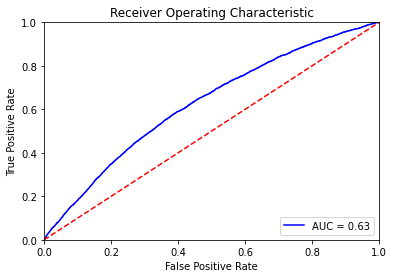

In [35]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(solver='liblinear')
logis.fit(X_train, y_train)

model_eval(logis, X_val, y_val)

# gestion desequilibre
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### gestion desequilibre
essai sous echantillonage

In [27]:
from imblearn.under_sampling import RandomUnderSampler

sample = RandomUnderSampler(random_state=1944)

# fit and apply the transform
X_under, y_under = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_under))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 19860, 1.0: 19860})


[[35285 21253]
 [ 2324  2641]]
Accuracy score    : 0.617
precision score   : 0.111
recall score      : 0.532
F1 score          : 0.183
F2 score          : 0.302
ROCAUC score      : 0.578
custom metric FMI : 0.242



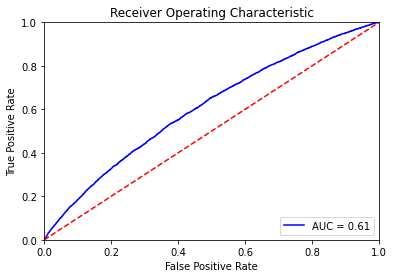

In [28]:
logis_under = LogisticRegression(solver='liblinear')
logis_under.fit(X_under, y_under)

model_eval(logis_under, X_val, y_val)

In [29]:
from imblearn.under_sampling import NearMiss


sample_undermiss = NearMiss()

# fit and apply the transform
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_undermiss))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 19860, 1.0: 19860})


[[24791 31747]
 [ 1740  3225]]
Accuracy score    : 0.456
precision score   : 0.0922
recall score      : 0.65
F1 score          : 0.162
F2 score          : 0.294
ROCAUC score      : 0.544
custom metric FMI : 0.245



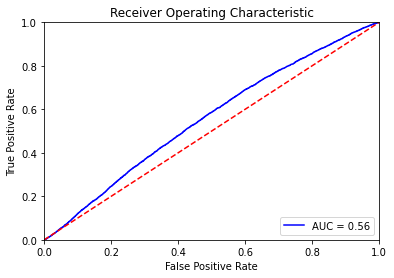

In [30]:
logis_undermiss = LogisticRegression(solver='liblinear')
logis_undermiss.fit(X_undermis, y_undermiss)

model_eval(logis_undermiss, X_val, y_val)

### gestion desequilibre
essai surechantillonage

In [31]:
from imblearn.over_sampling import SMOTE

sample = SMOTE(sampling_strategy=0.5, random_state=1944)

# fit and apply the transform
X_over, y_over = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_over))


Counter({0.0: 226148, 1.0: 19860})
Counter({0.0: 226148, 1.0: 113074})


[[55414  1124]
 [ 4702   263]]
Accuracy score    : 0.905
precision score   : 0.19
recall score      : 0.053
F1 score          : 0.0828
F2 score          : 0.0619
ROCAUC score      : 0.517
custom metric FMI : 0.1



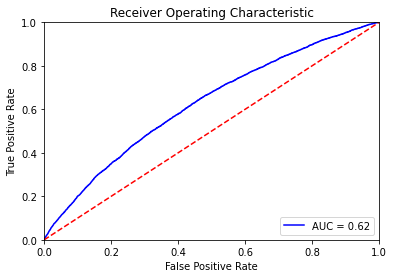

In [32]:
logis_over = LogisticRegression(solver='liblinear')
logis_over.fit(X_over, y_over)

model_eval(logis_over, X_val, y_val)

### gestion desequilibre
essai melange sous-echantillonage et surechantillonage

In [33]:
from imblearn.combine import SMOTEENN

sample = SMOTEENN(random_state=1944)

# fit and apply the transform
X_smote, y_smote = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_smote))


Counter({0.0: 226148, 1.0: 19860})
Counter({1.0: 207302, 0.0: 139787})


[[16729 39809]
 [  945  4020]]
Accuracy score    : 0.337
precision score   : 0.0917
recall score      : 0.81
F1 score          : 0.165
F2 score          : 0.316
ROCAUC score      : 0.553
custom metric FMI : 0.273



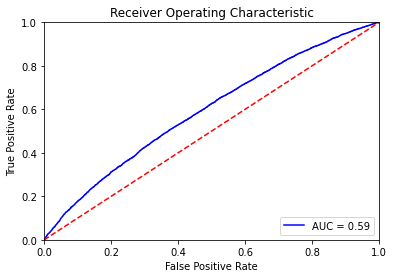

In [34]:
logis_smoteenn = LogisticRegression(solver='liblinear')
logis_smoteenn.fit(X_smote, y_smote)

model_eval(logis_smoteenn, X_val, y_val)

# Dectision Tree

[[51697  4841]
 [ 4150   815]]
Accuracy score    : 0.854
precision score   : 0.144
recall score      : 0.164
F1 score          : 0.153
F2 score          : 0.16
ROCAUC score      : 0.539
custom metric FMI : 0.154



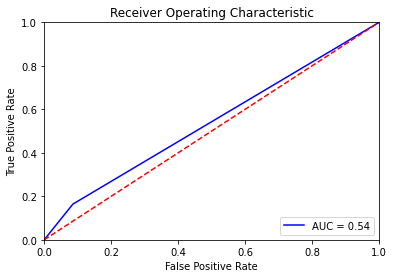

In [35]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier(random_state=1944)
dectree.fit(X_train, y_train)
model_eval(dectree, X_val, y_val)

In [36]:
from imblearn.over_sampling import SMOTE

sample_under = RandomUnderSampler(random_state=1944)
sample_over = SMOTE(sampling_strategy=0.5, random_state=1944)
sample_undermiss = NearMiss()
sample = SMOTEENN(random_state=1944)


# fit and apply the transform
X_under, y_under = sample_under.fit_resample(X_train, y_train)
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)
X_over, y_over = sample_over.fit_resample(X_train, y_train)
X_smote, y_smote = sample.fit_resample(X_train, y_train)

In [37]:
dectree_under = DecisionTreeClassifier(random_state=1944)
dectree_undermiss = DecisionTreeClassifier(random_state=1944)
dectree_over = DecisionTreeClassifier(random_state=1944)
dectree_smoteenn = DecisionTreeClassifier(random_state=1944)

dectree_under.fit(X_under, y_under)
dectree_undermiss.fit(X_undermis, y_undermiss)
dectree_over.fit(X_over, y_over)
dectree_smoteenn.fit(X_smote, y_smote)


DecisionTreeClassifier(random_state=1944)

[[33226 23312]
 [ 2052  2913]]
Accuracy score    : 0.588
precision score   : 0.111
recall score      : 0.587
F1 score          : 0.187
F2 score          : 0.316
ROCAUC score      : 0.587
custom metric FMI : 0.255



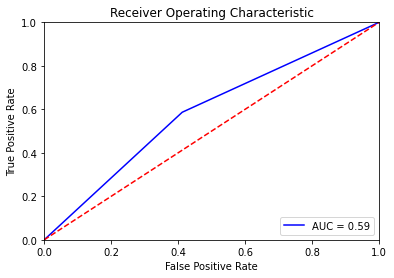

In [38]:
model_eval(dectree_under, X_val, y_val)

[[15496 41042]
 [ 1171  3794]]
Accuracy score    : 0.314
precision score   : 0.0846
recall score      : 0.764
F1 score          : 0.152
F2 score          : 0.293
ROCAUC score      : 0.519
custom metric FMI : 0.254



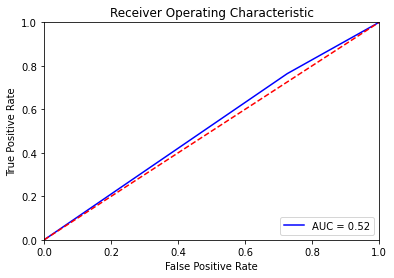

In [39]:
model_eval(dectree_undermiss, X_val, y_val)

[[51255  5283]
 [ 4105   860]]
Accuracy score    : 0.847
precision score   : 0.14
recall score      : 0.173
F1 score          : 0.155
F2 score          : 0.165
ROCAUC score      : 0.54
custom metric FMI : 0.156



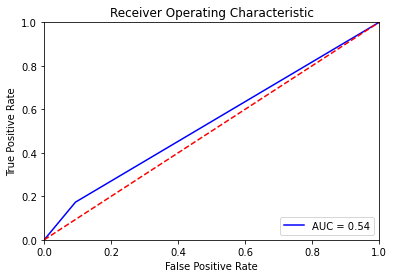

In [40]:
model_eval(dectree_over, X_val, y_val)

[[48994  7544]
 [ 3831  1134]]
Accuracy score    : 0.815
precision score   : 0.131
recall score      : 0.228
F1 score          : 0.166
F2 score          : 0.199
ROCAUC score      : 0.547
custom metric FMI : 0.173



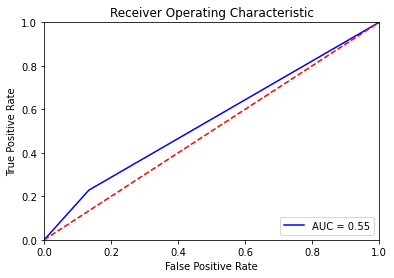

In [41]:
model_eval(dectree_smoteenn, X_val, y_val)

# RandomForest

[[56538     0]
 [ 4965     0]]
Accuracy score    : 0.919
precision score   : 0.0
recall score      : 0.0
F1 score          : 0.0
F2 score          : 0.0
ROCAUC score      : 0.5
custom metric FMI : nan



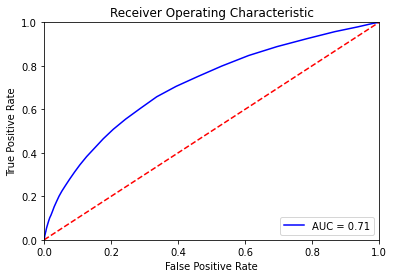

In [42]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(random_state=1944)

randomForest.fit(X_train, y_train)
model_eval(randomForest, X_val, y_val)

[[56519    19]
 [ 4943    22]]
Accuracy score    : 0.919
precision score   : 0.537
recall score      : 0.00443
F1 score          : 0.00879
F2 score          : 0.00553
ROCAUC score      : 0.502
custom metric FMI : 0.0488



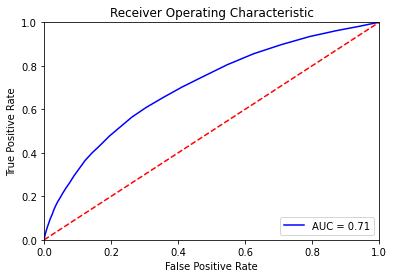

In [43]:
randomForest_weight = RandomForestClassifier(random_state=1944, class_weight={0:10,1:1})

randomForest_weight.fit(X_train, y_train)
model_eval(randomForest_weight, X_val, y_val)

In [44]:
randomForest_under = RandomForestClassifier(random_state=1944)
randomForest_undermiss = RandomForestClassifier(random_state=1944)
randomForest_over = RandomForestClassifier(random_state=1944)
randomForest_smoteenn = RandomForestClassifier(random_state=1944)

randomForest_under.fit(X_under, y_under)
randomForest_undermiss.fit(X_undermis, y_undermiss)
randomForest_over.fit(X_over, y_over)
randomForest_smoteenn.fit(X_smote, y_smote)


RandomForestClassifier(random_state=1944)

[[39506 17032]
 [ 1763  3202]]
Accuracy score    : 0.694
precision score   : 0.158
recall score      : 0.645
F1 score          : 0.254
F2 score          : 0.399
ROCAUC score      : 0.672
custom metric FMI : 0.319



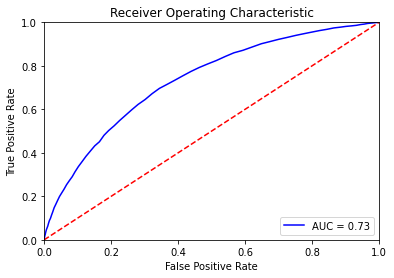

In [45]:
model_eval(randomForest_under, X_val, y_val)

[[16187 40351]
 [  991  3974]]
Accuracy score    : 0.328
precision score   : 0.0897
recall score      : 0.8
F1 score          : 0.161
F2 score          : 0.31
ROCAUC score      : 0.543
custom metric FMI : 0.268



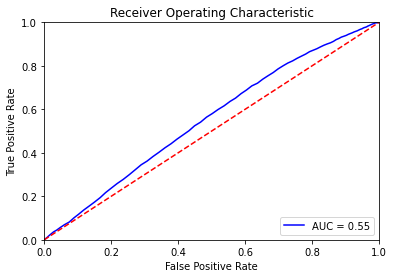

In [46]:
model_eval(randomForest_undermiss, X_val, y_val)

[[56538     0]
 [ 4963     2]]
Accuracy score    : 0.919
precision score   : 1.0
recall score      : 0.000403
F1 score          : 0.000805
F2 score          : 0.000503
ROCAUC score      : 0.5
custom metric FMI : 0.0201



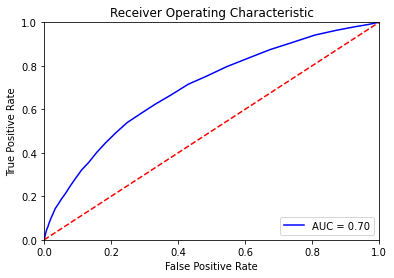

In [47]:
model_eval(randomForest_over, X_val, y_val)

[[56464    74]
 [ 4911    54]]
Accuracy score    : 0.919
precision score   : 0.422
recall score      : 0.0109
F1 score          : 0.0212
F2 score          : 0.0135
ROCAUC score      : 0.505
custom metric FMI : 0.0677



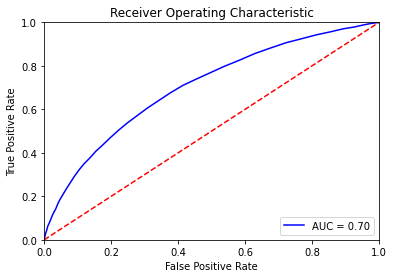

In [48]:
model_eval(randomForest_smoteenn, X_val, y_val)

### a priori RandomForest avec strategie d'underFitting semble la plus prometteuse

In [49]:
model_eval_score(dummyCls, X_val, y_val)

[[51889  4649]
 [ 4543   422]]
Accuracy score    : 0.851
precision score   : 0.0832
recall score      : 0.085
F1 score          : 0.0841
F2 score          : 0.0846
ROCAUC score      : 0.501
custom metric FMI : 0.0841



In [50]:
model_eval_score(logis_under, X_val, y_val)

[[35285 21253]
 [ 2324  2641]]
Accuracy score    : 0.617
precision score   : 0.111
recall score      : 0.532
F1 score          : 0.183
F2 score          : 0.302
ROCAUC score      : 0.578
custom metric FMI : 0.242



In [51]:
model_eval_score(dectree_under, X_val, y_val)

[[33226 23312]
 [ 2052  2913]]
Accuracy score    : 0.588
precision score   : 0.111
recall score      : 0.587
F1 score          : 0.187
F2 score          : 0.316
ROCAUC score      : 0.587
custom metric FMI : 0.255



In [52]:
model_eval_score(randomForest_under, X_val, y_val)

[[39506 17032]
 [ 1763  3202]]
Accuracy score    : 0.694
precision score   : 0.158
recall score      : 0.645
F1 score          : 0.254
F2 score          : 0.399
ROCAUC score      : 0.672
custom metric FMI : 0.319



In [54]:
from sklearn.model_selection import RandomizedSearchCV

random_grid_Forest = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features':  ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid_Forest)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rgf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1944), param_distributions = random_grid_Forest, scoring=custom_scorer, n_iter = 50, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rgf_random.fit(X_under, y_under)

print(rgf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 99.3min finished


{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


[[39305 17233]
 [ 1624  3341]]
Accuracy score    : 0.693
precision score   : 0.162
recall score      : 0.673
F1 score          : 0.262
F2 score          : 0.413
ROCAUC score      : 0.684
custom metric FMI : 0.331



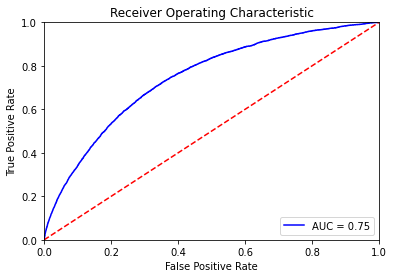

In [55]:
randomForest_under_random = RandomForestClassifier(random_state=1944, n_estimators = 1800, min_samples_split = 10,
                                                   min_samples_leaf = 4, max_features = 'sqrt', max_depth = 30, bootstrap = False)
randomForest_under_random.fit(X_under, y_under)
model_eval(randomForest_under_random, X_val, y_val)

In [52]:
model_eval_score(randomForest_under, X_val, y_val)

[[39506 17032]
 [ 1763  3202]]
Accuracy score    : 0.694
precision score   : 0.158
recall score      : 0.645
F1 score          : 0.254
F2 score          : 0.399
ROCAUC score      : 0.672
custom metric FMI : 0.319



# BOOSTING

In [37]:
from lightgbm import LGBMClassifier

lgbmc10 = LGBMClassifier(is_unbalance=True)

lgbmc10.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.804936	training's binary_logloss: 0.546661	valid_1's auc: 0.763736	valid_1's binary_logloss: 0.556667


LGBMClassifier(is_unbalance=True)

[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



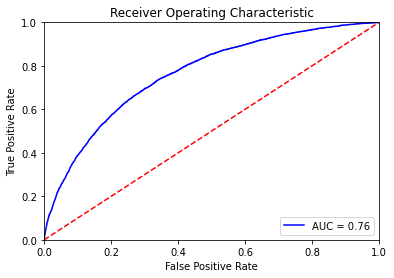

In [38]:
model_eval(lgbmc10, X_val, y_val)

In [39]:

def custom_lightgbm_valid(y_true, y_pred):
    TP = np.sum( (y_true==1) & (y_pred==1) )
    FP = np.sum( (y_true==0) & (y_pred==1) )
    TN = np.sum( (y_true==0) & (y_pred==0) )
    FN = np.sum( (y_true==1) & (y_pred==0) )
    precision  = TP / ( TP + FP )
    recall  = TP / ( TP + FN )
    f1_score = 2 * precision * recall / (precision + recall)
    f2_score = (5 * precision * recall) / (4 * precision + recall)
    return "F2 Score", f2_score, True
 
y_pred = lgbmc10.predict(X_val)
custom_lightgbm_valid(y_val, y_pred)

('F2 Score', 0.42833005497553833, True)

In [40]:
from sklearn.metrics import make_scorer

def custom_metric_light_gbm(y, y_pred):
    chaine, f2_score, dum = custom_lightgbm_valid(y, y_pred)
    return f2_score

y_pred = lgbmc10.predict(X_val)
print(custom_metric_light_gbm(y_val, y_pred))

custom_scorer_lgbm_f2 = make_scorer(custom_metric_light_gbm, greater_is_better=True )

0.42833005497553833


[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



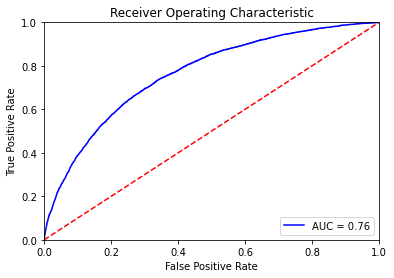

In [41]:
lgbmc10_custom = LGBMClassifier(is_unbalance=True)

lgbmc10_custom.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= custom_lightgbm_valid, verbose= 200)

model_eval(lgbmc10_custom, X_val, y_val)

{'num_leaves': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'min_child_samples': array([100, 200, 300, 400]), 'min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.8min finished


{'subsample': 0.8000000000000003, 'reg_lambda': 100, 'reg_alpha': 0, 'num_leaves': 50, 'min_child_weight': 100.0, 'min_child_samples': 400, 'colsample_bytree': 0.30000000000000004}
[[40514 16024]
 [ 1604  3361]]
Accuracy score    : 0.713
precision score   : 0.173
recall score      : 0.677
F1 score          : 0.276
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



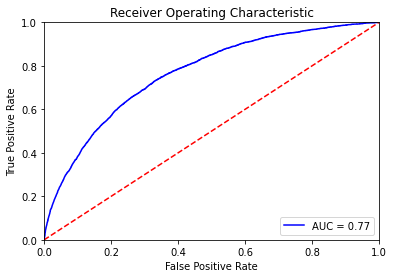

In [62]:
from sklearn.model_selection import RandomizedSearchCV

random_grid ={
            'num_leaves': np.arange(50,500,50),
            'min_child_samples': np.arange(100,500,100), 
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': np.arange(0.2,1,.1), 
            'colsample_bytree': np.arange(0.2,1,.1),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'), scoring=custom_scorer_lgbm_f2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(X_train, y_train)

print(lgbm_random.best_params_)

model_eval(lgbm_random.best_estimator_, X_val, y_val)

In [70]:
lgbmc10_randomCV = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc', subsample = 0.8, reg_lambda = 100, num_leaves = 50,
                                  min_child_weight = 100, min_child_samples = 400, colsample_bytree = 0.3)

lgbmc10_randomCV.fit(X_train, y_train, eval_metric= 'auc', verbose= 200)

LGBMClassifier(colsample_bytree=0.3, is_unbalance=True, metric='auc',
               min_child_samples=400, min_child_weight=100, num_leaves=50,
               objective='binary', reg_lambda=100, subsample=0.8)

[[40514 16024]
 [ 1604  3361]]
Accuracy score    : 0.713
precision score   : 0.173
recall score      : 0.677
F1 score          : 0.276
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



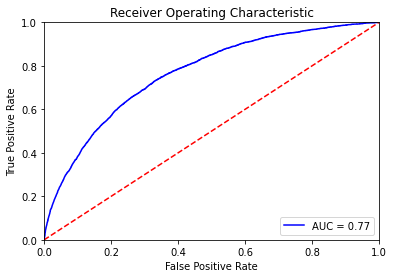

In [71]:
model_eval(lgbmc10_randomCV, X_val, y_val)

In [72]:
model_eval_score(lgbmc10, X_val, y_val)

[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



In [73]:
model_eval_score(lgbmc10_randomCV, X_val, y_val)

[[40514 16024]
 [ 1604  3361]]
Accuracy score    : 0.713
precision score   : 0.173
recall score      : 0.677
F1 score          : 0.276
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



# export des modeles simples applications

In [76]:
import pickle

with open('randomForest_model.p', 'wb') as f1:
    pickle.dump(randomForest_under, f1)
    
with open('lgbmc10.p', 'wb') as f1:
    pickle.dump(lgbmc10, f1)

with open('app_train.p', 'wb') as f1:
    pickle.dump(app_train, f1)
    

#  UTILISATION d'une selection dans le jeu complet de données

selection faite dans kernel kaggle : https://www.kaggle.com/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit

In [18]:
df_feats = pd.read_csv('df_feats.csv')

In [19]:
df_feats

,Unnamed: 0,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,...,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,NONLIVINGAPARTMENTS_MEDI,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0,1,100002,0.0,NaN,1.00000,6.0,NaN,NaN,NaN,...,0.0,351000.0,24.00,0,0,0.0000,40.5000,0,9251.775,49156.20
1,1,0,100003,0.0,NaN,1.00000,1.0,NaN,NaN,NaN,...,0.0,1129500.0,10.00,0,0,0.0039,0.0000,0,6662.970,0.00
2,2,0,100004,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,135000.0,4.00,0,0,NaN,NaN,0,5357.250,0.00
3,3,0,100006,0.0,NaN,1.00000,3.0,0.0,NaN,0.0,...,NaN,297000.0,18.00,0,0,NaN,NaN,0,2482.920,NaN
4,4,0,100007,0.0,NaN,1.00000,14.0,NaN,NaN,NaN,...,0.0,513000.0,20.67,0,0,NaN,NaN,0,0.180,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0,456251,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,8.00,0,0,0.0757,NaN,0,6605.910,NaN
307502,307502,0,456252,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,6.00,0,0,0.0000,NaN,0,10046.880,NaN
307503,307503,0,456253,5.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,585000.0,5.00,0,0,0.0000,NaN,0,27.270,448958.25
307504,307504,1,456254,0.0,NaN,1.00000,12.0,NaN,NaN,NaN,...,0.0,319500.0,15.00,0,0,NaN,NaN,0,2296.440,0.00


In [20]:
df_feats.drop(columns='Unnamed: 0', inplace=True)

In [42]:
import re
from collections import Counter

df_feats = df_feats.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_feats = df_feats.drop(columns='TARGET').copy()
y_feats = df_feats['TARGET'].copy()


In [43]:
from sklearn.model_selection import train_test_split

X_feats_train, X_feats_val, y_feats_train, y_feats_val = train_test_split(X_feats, y_feats, test_size=0.2, stratify=y_feats, random_state=1944)

In [44]:
print('y_feats_train', Counter(y_feats_train))
print('y_feats_val', Counter(y_feats_val))

y_feats_train Counter({0: 226145, 1: 19859})
y_feats_val Counter({0: 56537, 1: 4965})


### MODELISATION avec Algorithme LightGBM

[[41045 15492]
 [ 1500  3465]]
Accuracy score    : 0.724
precision score   : 0.183
recall score      : 0.698
F1 score          : 0.29
F2 score          : 0.446
ROCAUC score      : 0.712
custom metric FMI : 0.357



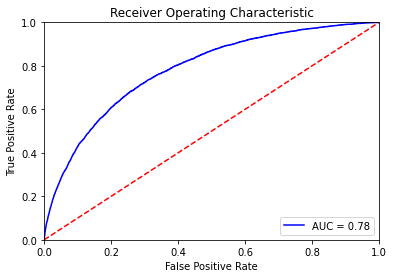

In [45]:
from lightgbm import LGBMClassifier

lgbmc10_feats_custom = LGBMClassifier(is_unbalance=True)

lgbmc10_feats_custom.fit(X_feats_train, y_feats_train, eval_set=[(X_feats_train, y_feats_train), (X_feats_val, y_feats_val)], 
    eval_metric= custom_lightgbm_valid, verbose= 200)

model_eval(lgbmc10_feats_custom, X_feats_val, y_feats_val)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid ={
            'num_leaves': np.arange(50,500,50),
            'min_child_samples': np.arange(100,500,100), 
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': np.arange(0.2,1,.1), 
            'colsample_bytree': np.arange(0.2,1,.1),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_feats_randomCV = RandomizedSearchCV(estimator = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'), scoring=custom_scorer_lgbm_f2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
lgbm_feats_randomCV.fit(X_feats_train, y_feats_train)

print(lgbm_feats_randomCV.best_params_)
lgbm_feats_random = lgbm_feats_randomCV.best_estimator_
model_eval(lgbm_feats_random, X_feats_val, y_feats_val)

{'num_leaves': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'min_child_samples': array([100, 200, 300, 400]), 'min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min


In [72]:
model_eval_score(lgbm_feats_random, X_val, y_val)

[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



In [46]:
model_eval_score(lgbmc10_feats_custom, X_feats_val, y_feats_val)

[[41045 15492]
 [ 1500  3465]]
Accuracy score    : 0.724
precision score   : 0.183
recall score      : 0.698
F1 score          : 0.29
F2 score          : 0.446
ROCAUC score      : 0.712
custom metric FMI : 0.357



In [72]:
model_eval_score(lgbmc10, X_val, y_val)

[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



In [127]:
with open('lgbm_feats_random.p', 'wb') as f4:
    pickle.dump(lgbm_feats_random, f4)

with open('lgbmc10_feats_custom.p', 'wb') as f4:
    pickle.dump(lgbmc10_feats_custom, f4)

    
